# Self made SVD

In [1]:
import helpers
import pandas as pd
import numpy as np
import scipy.sparse as sparse
from collections import defaultdict
from itertools import chain
import random

train_read=pd.read_csv('./Datasets/ml-100k/train.csv', sep='\t', header=None)
test_read=pd.read_csv('./Datasets/ml-100k/test.csv', sep='\t', header=None)
train_ui, test_ui, user_code_id, user_id_code, item_code_id, item_id_code = helpers.data_to_csr(train_read, test_read)

In [2]:
# Done similarly to https://github.com/albertauyeung/matrix-factorization-in-python
from tqdm import tqdm

class SVD():
    
    def __init__(self, train_ui, learning_rate, regularization, nb_factors, iterations):
        self.train_ui=train_ui
        self.uir=list(zip(*[train_ui.nonzero()[0],train_ui.nonzero()[1], train_ui.data]))
        
        self.learning_rate=learning_rate
        self.regularization=regularization
        self.iterations=iterations
        self.nb_users, self.nb_items=train_ui.shape
        self.nb_ratings=train_ui.nnz
        self.nb_factors=nb_factors
        
        self.Pu=np.random.normal(loc=0, scale=1./self.nb_factors, size=(self.nb_users, self.nb_factors))
        self.Qi=np.random.normal(loc=0, scale=1./self.nb_factors, size=(self.nb_items, self.nb_factors))

    def train(self, test_ui=None):
        if test_ui!=None:
            self.test_uir=list(zip(*[test_ui.nonzero()[0],test_ui.nonzero()[1], test_ui.data]))
            
        self.learning_process=[]
        pbar = tqdm(range(self.iterations))
        for i in pbar:
            pbar.set_description(f'Epoch {i} RMSE: {self.learning_process[-1][1] if i>0 else 0}. Training epoch {i+1}...')
            np.random.shuffle(self.uir)
            self.sgd(self.uir)
            if test_ui==None:
                self.learning_process.append([i+1, self.RMSE_total(self.uir)])
            else:
                self.learning_process.append([i+1, self.RMSE_total(self.uir), self.RMSE_total(self.test_uir)])
    
    def sgd(self, uir):
        
        for u, i, score in uir:
            # Computer prediction and error
            prediction = self.get_rating(u,i)
            e = (score - prediction)
            
            # Update user and item latent feature matrices
            Pu_update=self.learning_rate * (e * self.Qi[i] - self.regularization * self.Pu[u])
            Qi_update=self.learning_rate * (e * self.Pu[u] - self.regularization * self.Qi[i])
            
            self.Pu[u] += Pu_update
            self.Qi[i] += Qi_update
        
    def get_rating(self, u, i):
        prediction = self.Pu[u].dot(self.Qi[i].T)
        return prediction
    
    def RMSE_total(self, uir):
        RMSE=0
        for u,i, score in uir:
            prediction = self.get_rating(u,i)
            RMSE+=(score - prediction)**2
        return np.sqrt(RMSE/len(uir))
    
    def estimations(self):
        self.estimations=\
        np.dot(self.Pu,self.Qi.T)

    def recommend(self, user_code_id, item_code_id, topK=10):
        
        top_k = defaultdict(list)
        for nb_user, user in enumerate(self.estimations):
            
            user_rated=self.train_ui.indices[self.train_ui.indptr[nb_user]:self.train_ui.indptr[nb_user+1]]
            for item, score in enumerate(user):
                if item not in user_rated and not np.isnan(score):
                    top_k[user_code_id[nb_user]].append((item_code_id[item], score))
        result=[]
        # Let's choose k best items in the format: (user, item1, score1, item2, score2, ...)
        for uid, item_scores in top_k.items():
            item_scores.sort(key=lambda x: x[1], reverse=True)
            result.append([uid]+list(chain(*item_scores[:topK])))
        return result
    
    def estimate(self, user_code_id, item_code_id, test_ui):
        result=[]
        for user, item in zip(*test_ui.nonzero()):
            result.append([user_code_id[user], item_code_id[item], 
                           self.estimations[user,item] if not np.isnan(self.estimations[user,item]) else 1])
        return result

In [3]:
model=SVD(train_ui, learning_rate=0.005, regularization=0.02, nb_factors=100, iterations=40)
model.train(test_ui)

Epoch 39 RMSE: 0.7476169311403564. Training epoch 40...: 100%|██████████| 40/40 [01:47<00:00,  2.68s/it]


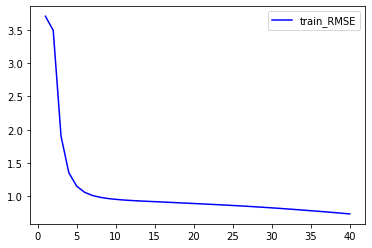

In [4]:
import matplotlib.pyplot as plt

df=pd.DataFrame(model.learning_process).iloc[:,:2]
df.columns=['epoch', 'train_RMSE']
plt.plot('epoch', 'train_RMSE', data=df, color='blue')
plt.legend()

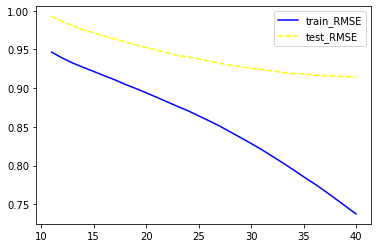

In [5]:
import matplotlib.pyplot as plt

df=pd.DataFrame(model.learning_process[10:], columns=['epoch', 'train_RMSE', 'test_RMSE'])
plt.plot('epoch', 'train_RMSE', data=df, color='blue')
plt.plot('epoch', 'test_RMSE', data=df, color='yellow', linestyle='dashed')
plt.legend()

#### Saving and evaluating recommendations

In [6]:
model.estimations()

top_n=pd.DataFrame(model.recommend(user_code_id, item_code_id, topK=10))

top_n.to_csv('Recommendations generated/ml-100k/Self_SVD_reco.csv', index=False, header=False)

estimations=pd.DataFrame(model.estimate(user_code_id, item_code_id, test_ui))
estimations.to_csv('Recommendations generated/ml-100k/Self_SVD_estimations.csv', index=False, header=False)

In [7]:
import evaluation_measures as ev

estimations_df=pd.read_csv('Recommendations generated/ml-100k/Self_SVD_estimations.csv', header=None)
reco=np.loadtxt('Recommendations generated/ml-100k/Self_SVD_reco.csv', delimiter=',')

ev.evaluate(test=pd.read_csv('./Datasets/ml-100k/test.csv', sep='\t', header=None),
            estimations_df=estimations_df, 
            reco=reco,
            super_reactions=[4,5])

943it [00:00, 5237.55it/s]


RMSE       MAE  precision    recall       F_1     F_05  \
0  0.913861  0.717063    0.10403  0.044109  0.053339  0.07051   

   precision_super  recall_super      NDCG       mAP       MRR      LAUC  \
0         0.094313      0.075814  0.107692  0.051047  0.201273  0.518782   

         HR  Reco in test  Test coverage   Shannon      Gini  
0  0.481442       0.87211       0.146465  3.881417  0.972029

In [8]:
import imp
imp.reload(ev)

import evaluation_measures as ev
dir_path="Recommendations generated/ml-100k/"
super_reactions=[4,5]
test=pd.read_csv('./Datasets/ml-100k/test.csv', sep='\t', header=None)

ev.evaluate_all(test, dir_path, super_reactions)

943it [00:00, 6996.89it/s]
943it [00:00, 5574.45it/s]
943it [00:00, 5909.51it/s]
943it [00:00, 6568.51it/s]
943it [00:00, 5488.25it/s]
943it [00:00, 5363.29it/s]
943it [00:00, 6280.36it/s]
943it [00:00, 5709.71it/s]
943it [00:00, 6279.20it/s]
943it [00:00, 5819.38it/s]


Model      RMSE       MAE  precision    recall       F_1  \
0          Self_TopPop  2.508258  2.217909   0.188865  0.116919  0.118732   
0             Self_SVD  0.913861  0.717063   0.104030  0.044109  0.053339   
0       Ready_Baseline  0.949459  0.752487   0.091410  0.037652  0.046030   
0       Self_GlobalAvg  1.125760  0.943534   0.061188  0.025968  0.031383   
0         Ready_Random  1.517787  1.217953   0.047826  0.017861  0.022711   
0          Ready_I-KNN  1.030386  0.813067   0.026087  0.006908  0.010593   
0  Ready_I-KNNBaseline  0.935327  0.737424   0.002545  0.000755  0.001105   
0          Ready_U-KNN  1.023495  0.807913   0.000742  0.000205  0.000305   
0      Self_BaselineUI  0.967585  0.762740   0.000954  0.000170  0.000278   
0            Self_IKNN  1.018363  0.808793   0.000318  0.000108  0.000140   

       F_05  precision_super  recall_super      NDCG       mAP       MRR  \
0  0.141584         0.130472      0.137473  0.214651  0.111707  0.400939   
0  0.070510         0.094313      0.075814  0.107692  0.051047  0.201273   
0  0.061286         0.079614      0.056463  0.095957  0.043178  0.198193   
0  0.041343         0.040558      0.032107  0.067695  0.027470  0.171187   
0  0.031080         0.028219      0.016982  0.051154  0.019551  0.125693   
0  0.016046         0.021137      0.009522  0.024214  0.008958  0.048068   
0  0.001602         0.002253      0.000930  0.003444  0.001362  0.011760   
0  0.000449         0.000536      0.000198  0.000845  0.000274  0.002744   
0  0.000463         0.000644      0.000189  0.000752  0.000168  0.001677   
0  0.000189         0.000000      0.000000  0.000214  0.000037  0.000368   

       LAUC        HR  Reco in test  Test coverage   Shannon      Gini  
0  0.555546  0.765642      1.000000       0.038961  3.159079  0.987317  
0  0.518782  0.481442      0.872110       0.146465  3.881417  0.972029  
0  0.515501  0.437964      1.000000       0.033911  2.836513  0.991139  
0  0.509546  0.384942      1.000000       0.025974  2.711772  0.992003  
0  0.505448  0.318134      0.986426       0.186869  5.091730  0.908288  
0  0.499885  0.154825      0.402333       0.434343  5.133650  0.877999  
0  0.496724  0.021209      0.482821       0.059885  2.232578  0.994487  
0  0.496441  0.007423      0.602121       0.010823  2.089186  0.995706  
0  0.496424  0.009544      0.600530       0.005051  1.803126  0.996380  
0  0.496391  0.003181      0.392153       0.115440  4.174741  0.965327

### Embeddings

In [9]:
x=np.array([[1,2],[3,4]])
display(x)
x/np.linalg.norm(x, axis=1)[:,None]

array([[1, 2],
       [3, 4]])

array([[0.4472136 , 0.89442719],
       [0.6       , 0.8       ]])

In [10]:
item=random.choice(list(set(train_ui.indices)))

embeddings_norm=model.Qi/np.linalg.norm(model.Qi, axis=1)[:,None] # we do not mean-center here
# omitting normalization also makes sense, but items with a greater magnitude will be recommended more often

similarity_scores=np.dot(embeddings_norm,embeddings_norm[item].T)
top_similar_items=pd.DataFrame(enumerate(similarity_scores), columns=['code', 'score'])\
.sort_values(by=['score'], ascending=[False])[:10]

top_similar_items['item_id']=top_similar_items['code'].apply(lambda x: item_code_id[x])

items=pd.read_csv('./Datasets/ml-100k/movies.csv')

result=pd.merge(top_similar_items, items, left_on='item_id', right_on='id')

result

code     score  item_id    id                               title  \
0  1051  1.000000     1052  1052  Dracula: Dead and Loving It (1995)   
1  1177  0.951303     1178  1178                  Major Payne (1994)   
2  1290  0.950489     1291  1291                 Celtic Pride (1996)   
3  1375  0.949864     1376  1376            Meet Wally Sparks (1997)   
4  1489  0.947375     1490  1490                       Fausto (1993)   
5  1495  0.947368     1496  1496                      Carpool (1996)   
6  1497  0.947347     1498  1498               Farmer & Chase (1995)   
7  1490  0.946829     1491  1491             Tough and Deadly (1995)   
8  1320  0.946152     1321  1321                  Open Season (1996)   
9  1487  0.945425     1488  1488                     Germinal (1993)   

                    genres  
0           Comedy, Horror  
1                   Comedy  
2                   Comedy  
3                   Comedy  
4                   Comedy  
5            Comedy, Crime  
6                   Comedy  
7  Action, Drama, Thriller  
8                   Comedy  
9                    Drama

# project task 5:  implement SVD on top baseline (as it is in Surprise library)

In [11]:
# making changes to our implementation by considering additional parameters in the gradient descent procedure 
# seems to be the fastest option
# please save the output in 'Recommendations generated/ml-100k/Self_SVDBaseline_reco.csv' and
# 'Recommendations generated/ml-100k/Self_SVDBaseline_estimations.csv'

# Ready-made SVD - Surprise implementation

### SVD

In [12]:
import helpers
import surprise as sp
import imp
imp.reload(helpers)

algo = sp.SVD(biased=False) # to use unbiased version

helpers.ready_made(algo, reco_path='Recommendations generated/ml-100k/Ready_SVD_reco.csv',
          estimations_path='Recommendations generated/ml-100k/Ready_SVD_estimations.csv')

Generating predictions...
Generating top N recommendations...
Generating predictions...


### SVD biased - on top baseline

In [13]:
import helpers
import surprise as sp
import imp
imp.reload(helpers)

algo = sp.SVD() # default is biased=True

helpers.ready_made(algo, reco_path='Recommendations generated/ml-100k/Ready_SVDBiased_reco.csv',
          estimations_path='Recommendations generated/ml-100k/Ready_SVDBiased_estimations.csv')

Generating predictions...
Generating top N recommendations...
Generating predictions...


In [14]:
import imp
imp.reload(ev)

import evaluation_measures as ev
dir_path="Recommendations generated/ml-100k/"
super_reactions=[4,5]
test=pd.read_csv('./Datasets/ml-100k/test.csv', sep='\t', header=None)

ev.evaluate_all(test, dir_path, super_reactions)

943it [00:00, 5528.02it/s]
943it [00:00, 6531.06it/s]
943it [00:00, 5593.54it/s]
943it [00:00, 5845.59it/s]
943it [00:00, 5997.91it/s]
943it [00:00, 6080.78it/s]
943it [00:00, 6121.00it/s]
943it [00:00, 5934.94it/s]
943it [00:00, 5026.29it/s]
943it [00:00, 5850.46it/s]
943it [00:00, 5530.89it/s]
943it [00:00, 6004.16it/s]


Model      RMSE       MAE  precision    recall       F_1  \
0          Self_TopPop  2.508258  2.217909   0.188865  0.116919  0.118732   
0            Ready_SVD  0.949892  0.749292   0.104666  0.048611  0.055656   
0             Self_SVD  0.913861  0.717063   0.104030  0.044109  0.053339   
0       Ready_Baseline  0.949459  0.752487   0.091410  0.037652  0.046030   
0      Ready_SVDBiased  0.942994  0.743492   0.083351  0.034097  0.041677   
0       Self_GlobalAvg  1.125760  0.943534   0.061188  0.025968  0.031383   
0         Ready_Random  1.517787  1.217953   0.047826  0.017861  0.022711   
0          Ready_I-KNN  1.030386  0.813067   0.026087  0.006908  0.010593   
0  Ready_I-KNNBaseline  0.935327  0.737424   0.002545  0.000755  0.001105   
0          Ready_U-KNN  1.023495  0.807913   0.000742  0.000205  0.000305   
0      Self_BaselineUI  0.967585  0.762740   0.000954  0.000170  0.000278   
0            Self_IKNN  1.018363  0.808793   0.000318  0.000108  0.000140   

       F_05  precision_super  recall_super      NDCG       mAP       MRR  \
0  0.141584         0.130472      0.137473  0.214651  0.111707  0.400939   
0  0.071900         0.092811      0.078241  0.117730  0.057464  0.244097   
0  0.070510         0.094313      0.075814  0.107692  0.051047  0.201273   
0  0.061286         0.079614      0.056463  0.095957  0.043178  0.198193   
0  0.055673         0.073283      0.052910  0.091866  0.042598  0.198210   
0  0.041343         0.040558      0.032107  0.067695  0.027470  0.171187   
0  0.031080         0.028219      0.016982  0.051154  0.019551  0.125693   
0  0.016046         0.021137      0.009522  0.024214  0.008958  0.048068   
0  0.001602         0.002253      0.000930  0.003444  0.001362  0.011760   
0  0.000449         0.000536      0.000198  0.000845  0.000274  0.002744   
0  0.000463         0.000644      0.000189  0.000752  0.000168  0.001677   
0  0.000189         0.000000      0.000000  0.000214  0.000037  0.000368   

       LAUC        HR  Reco in test  Test coverage   Shannon      Gini  
0  0.555546  0.765642      1.000000       0.038961  3.159079  0.987317  
0  0.521054  0.501591      0.998091       0.217172  4.458001  0.951551  
0  0.518782  0.481442      0.872110       0.146465  3.881417  0.972029  
0  0.515501  0.437964      1.000000       0.033911  2.836513  0.991139  
0  0.513705  0.423118      0.997561       0.168831  4.195234  0.963319  
0  0.509546  0.384942      1.000000       0.025974  2.711772  0.992003  
0  0.505448  0.318134      0.986426       0.186869  5.091730  0.908288  
0  0.499885  0.154825      0.402333       0.434343  5.133650  0.877999  
0  0.496724  0.021209      0.482821       0.059885  2.232578  0.994487  
0  0.496441  0.007423      0.602121       0.010823  2.089186  0.995706  
0  0.496424  0.009544      0.600530       0.005051  1.803126  0.996380  
0  0.496391  0.003181      0.392153       0.115440  4.174741  0.965327